In [91]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

In [92]:
import orbit
import tensorflow_models as tfm 
from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.10.1


In [93]:
train_data_input_path = "../../data/tf_records/train/-00000-of-00001.tfrecord"
test_data_input_path = "../../data/tf_records/test/-00000-of-00001.tfrecord"
model_dir = 'trained_model/'
export_dir ='exported_model/'

In [94]:
exp_config = exp_factory.get_exp_config('retinanet_mobile_coco')
print(type(exp_config))

<class 'official.core.config_definitions.ExperimentConfig'>


In [95]:
#model and dataset config:
labels = ['kebab', 'chicken', 'beef', 'impossible', 'burrito', 'veggie', 'quesadilla', 'hummus', 'guacamole', 'cheese', 'bowl', 'salmon', 'tacos']
batch_size = 4
num_classes = len(labels)

HEIGHT, WIDTH = 512, 640
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation data config.
exp_config.task.validation_data.input_path = test_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

In [96]:
#trainer config:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]
print(logical_device_names)
if 'GPU' in ''.join(logical_device_names):
  print('GPU env')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('TPU env')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 2000
exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = 100
exp_config.trainer.validation_interval = 100
exp_config.trainer.validation_steps =  100 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

['/device:CPU:0', '/device:GPU:0']
GPU env


In [97]:
pp.pprint(exp_config.as_dict())

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'float32',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'worker_hosts': None},
    'task': {   'annotation_file': '',
                'differential_privacy_config': None,
                'export_config': {   'cast_detection_classes_to_float': False,
                      

In [98]:
#distribution strategy:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Done


In [99]:
#task object:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [100]:
#visualize sample batch of data:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')


images.shape: (4, 512, 640, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['cls_targets', 'box_targets', 'anchor_boxes', 'cls_weights', 'box_weights', 'image_info'])


In [101]:
category_index_dict = {
  0:{
      "id": 0,
      "name": "beef"
    },
  1:{
      "id": 1,
      "name": "bowl"
    },
  2:{
      "id": 2,
      "name": "burrito"
    },
  3:{
      "id": 3,
      "name": "cheese"
    },
  4:{
      "id": 4,
      "name": "chicken"
    },
  5:{
      "id": 5,
      "name": "guacamole"
    },
  6:{
      "id": 6,
      "name": "hummus"
    },
  7:{
      "id": 7,
      "name": "impossible"
    },
  8:{
      "id": 8,
      "name": "kebab"
    },
  9:{
      "id": 9,
      "name": "quesadilla"
    },
  10:{
      "id": 10,
      "name": "salmon"
    },
  11:{
      "id": 11,
      "name": "tacos"
    },
  12:{
      "id": 12,
      "name": "veggie"
    }
}
tf_ex_decoder = TfExampleDecoder()

In [102]:
#function to visualize from TFRrecords:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index = category_index_dict,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=1,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

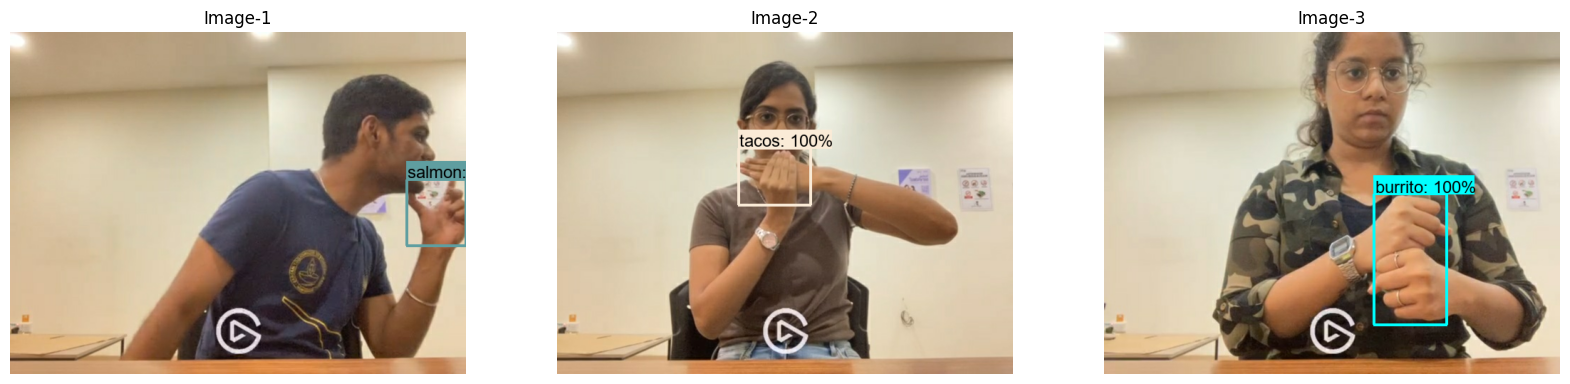

In [103]:
#ground truth visualization:
buffer_size = 500
num_of_examples = 3
raw_records = tf.data.TFRecordDataset(exp_config.task.train_data.input_path).shuffle(buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

In [104]:
#train and eval:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...
initialized model.
train | step:      0 | training until step 100...


train | step:    100 | steps/sec:    0.8 | output: 
    {'box_loss': 0.01180148,
     'cls_loss': 1.4142079,
     'learning_rate': 0.09938442,
     'model_loss': 2.0042822,
     'total_loss': 2.3299737,
     'training_loss': 2.3299737}
saved checkpoint to trained_model/ckpt-100.
 eval | step:    100 | running 100 steps of evaluation...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

In [105]:
#save and export model:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir
    )

INFO:tensorflow:Assets written to: exported_model/assets


INFO:tensorflow:Assets written to: exported_model/assets


In [106]:
#import saved model:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

In [107]:
def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

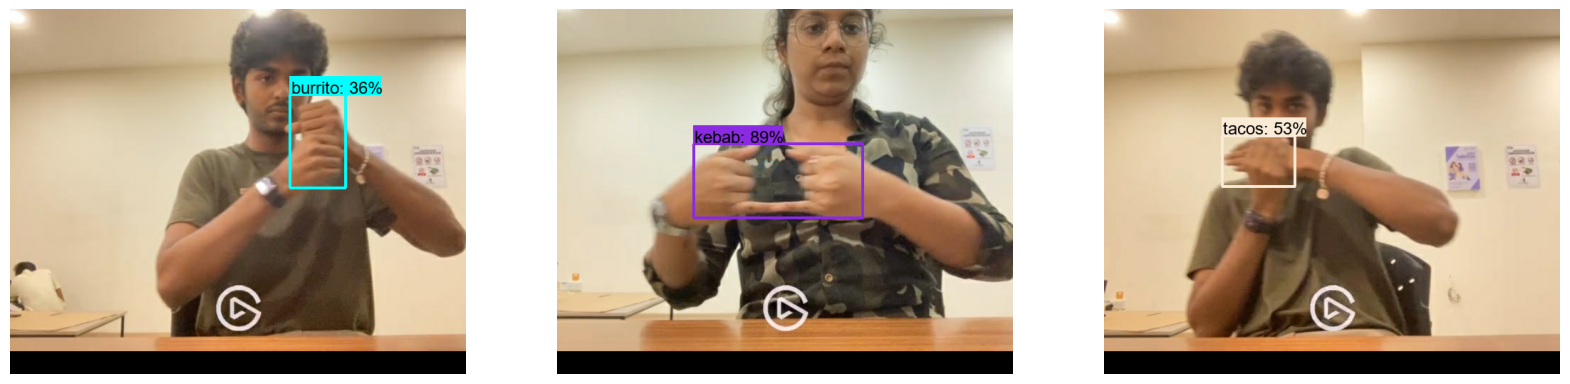

In [119]:
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.35 # Change minimum score for threshold to see all bounding boxes confidences.

buffer_size = 1000
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(
    exp_config.task.validation_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
# show_batch(raw_records, num_of_examples)

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index_dict,
      use_normalized_coordinates=False,
      max_boxes_to_draw=1,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')
plt.show()